# Demo of building curve

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import curve
import curveman
import curveng
import cminstruments as inst

## Define instruments which we calibrate curves to

In [13]:
grids_fixed_ois = [7/365, 1/12, 2/12, 3/12, 6/12, 9/12, 1]
fixed_ois = [inst.ZeroRate(0, end, 'JPY-OIS') for end in grids_fixed_ois]
fixed_ois_rates = np.array([0.001, 0.001, 0.0015, 0.002, 0.0022, 0.003, 0.0035])

In [46]:
start_fra = [0, 3/12, 6/12]
end_fra = [6/12, 9/12, 1]
fra = [inst.SimpleRate(start, end, 'JPY-LIBOR') for start, end in zip(start_fra ,end_fra)]
fra_rates = [0.004, 0.006, 0.008]

## Create CurveManager

In [47]:
cm = curveman.CurveManager()

## Define curves and register them to CurveManager

In [48]:
grids_ois = [7/365, 1/12, 0.4, 0.6, 1]
dfs_ois = np.ones((len(grids_ois), ))
ois_base = curve.Curve(grids_ois, dfs_ois, 'log_linear')
cm.append_curve('JPY-OIS-BASE', ois_base)

turn1_from = 0.2
turn1_to = 0.21
turn1_size = 0.0
turn1 = curve.TurnCurve(turn1_from, turn1_to, turn1_size)
cm.append_curve('JPY-Turn1', turn1)

turn2_from = 0.7
turn2_to = 0.71
turn2_size = 0.0
turn2 = curve.TurnCurve(turn2_from, turn2_to, turn2_size)
cm.append_curve('JPY-Turn2', turn2)

cm.register_basis_curve('JPY-OIS',
                        ['JPY-OIS-BASE', 'JPY-Turn1', 'JPY-Turn2'])

In [55]:
grids_lo = end_fra
dfs_lo = np.ones((len(grids_lo), ))
lo = curve.Curve(grids_lo, dfs_lo, 'monotone_convex')
cm.append_curve('JPY-LO', lo)

cm.register_basis_curve('JPY-LIBOR',
                        ['JPY-OIS', 'JPY-LO'])

show the curves' degree of freedom

In [56]:
print(cm.get_grids())

[('JPY-OIS-BASE', 5), ('JPY-Turn1', 1), ('JPY-Turn2', 1), ('JPY-LO', 3)]


## Prepare loss function and create CurveEngine

In [57]:
loss = lambda xs, ys: np.sum((np.array(xs) - np.array(ys))**2)
ce = curveng.CurveEngine(cm,
                         fixed_ois + fra,
                         loss)

## Build curve

In [58]:
%%time
cm = ce.build_curve(np.concatenate((fixed_ois_rates, fra_rates)))

/Users/yuseki/Documents/Financial/curve/interpolation.py:105: RuntimeWarning: invalid value encountered in true_divide
  eta = 1 + 3. * g0 / (g1 - g0)
/Users/yuseki/Documents/Financial/curve/interpolation.py:109: RuntimeWarning: invalid value encountered in true_divide
  eta = 3. * g1 / (g1 - g0)
/Users/yuseki/Documents/Financial/curve/interpolation.py:113: RuntimeWarning: invalid value encountered in true_divide
  eta = g1 / (g0 + g1)
/Users/yuseki/Documents/Financial/curve/interpolation.py:114: RuntimeWarning: invalid value encountered in true_divide
  A = -g0 * g1 / (g0 + g1)
/Users/yuseki/Documents/Financial/curve/interpolation.py:105: RuntimeWarning: divide by zero encountered in true_divide
  eta = 1 + 3. * g0 / (g1 - g0)
/Users/yuseki/Documents/Financial/curve/interpolation.py:106: RuntimeWarning: invalid value encountered in multiply
  Gii = g0 * x + np.where(x < eta, 0, (g1 - g0) * (x - eta)**3 / (1 - eta)**2 / 3.)
/Users/yuseki/Documents/Financial/curve/interpolation.py:109: 

CPU times: user 16.5 s, sys: 40.1 ms, total: 16.5 s
Wall time: 16.5 s


## show the accuracy of calibration 

In [59]:
ois_evaluated = np.array([ois.par_rate(cm) for ois in fixed_ois])
fra_evaluated = np.array([inst.par_rate(cm) for inst in fra])
print('calibrated ois :', ois_evaluated)
print('calibrated fra :', fra_evaluated)

print('ois market rates :', fixed_ois_rates)
print('fra market rates :', fra_rates)

calibrated ois : [0.00099974 0.00100042 0.00150037 0.00199974 0.00220014 0.0030005
 0.00350062]
calibrated fra : [[0.00400029]
 [0.00600096]
 [0.00800032]]
ois market rates : [0.001  0.001  0.0015 0.002  0.0022 0.003  0.0035]
fra market rates : [0.004, 0.006, 0.008]


## Plot the forward curve

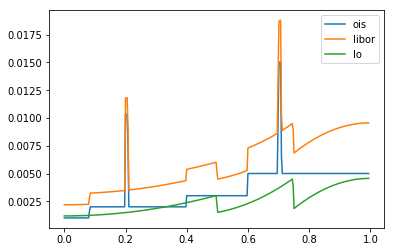

In [60]:
ts = np.arange(0, 1, 1/365)
df_ois = cm.get_curve('JPY-OIS').get_df(ts)
df_libor = cm.get_curve('JPY-LIBOR').get_df(ts)

fwd_ois = -np.log(df_ois[1:] / df_ois[:-1]) / (ts[1:] - ts[:-1])
fwd_libor = -np.log(df_libor[1:] / df_libor[:-1]) / (ts[1:] - ts[:-1])
plt.plot(ts[:-1], fwd_ois, label = 'ois')
plt.plot(ts[:-1], fwd_libor, label = 'libor')
plt.plot(ts[:-1], fwd_libor - fwd_ois, label = 'lo')

plt.legend()
plt.show()